In [ ]:
!nvidia-smi

In [1]:
from __future__ import print_function
import keras
from keras import metrics
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

import tensorflow as tf
# 自動增長 GPU 記憶體用量
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# 設定 Keras 使用的 Session
tf.keras.backend.set_session(sess)


Using TensorFlow backend.


In [2]:
import os
img_base_path = '/home/z99792458/nbs/Dataset/img_defects/hci_defect_datasets/'
class1_path = os.path.join(img_base_path, 'Class10')
class1_train_path = os.path.join(class1_path, 'Train')
class1_test_path = os.path.join(class1_path, 'Test')
labeled_img = [x[:4] for x in os.listdir(os.path.join(class1_train_path, 'Label'))] + [x[:4] for x in os.listdir(os.path.join(class1_test_path, 'Label'))]
labeled_img = list(set(labeled_img))
all_img = [x for x in os.listdir(class1_train_path) if x.find('_256') >-1] + [x for x in os.listdir(class1_test_path) if x.find('_256') >-1]
normal_img_name = [x for x in all_img if x[:4] not in labeled_img]
defect_img_name = [x for x in all_img if x[:4] in labeled_img]
train_img_names, test_img_names = train_test_split(normal_img_name, test_size=0.25)

train_imgs = list()
test_imgs = list()
for img_name in os.listdir(class1_train_path):
    if (img_name in train_img_names) and (img_name.find('_256') > -1) and (img_name.find('PNG') > -1):
        img = cv2.imread(os.path.join(class1_train_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = img.reshape(img.shape[0], img.shape[1], 1)
            train_imgs.append(img)
    if (img_name in test_img_names) and (img_name.find('_256') > -1) and (img_name.find('PNG') > -1):
        img = cv2.imread(os.path.join(class1_train_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = img.reshape(img.shape[0], img.shape[1], 1)
            test_imgs.append(img)

for img_name in os.listdir(class1_test_path):
    if (img_name in train_img_names) and (img_name.find('_256') > -1) and (img_name.find('PNG') > -1):
        img = cv2.imread(os.path.join(class1_test_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = img.reshape(img.shape[0], img.shape[1], 1)
            train_imgs.append(img)
    if (img_name in test_img_names) and (img_name.find('_256') > -1) and (img_name.find('PNG') > -1):
        img = cv2.imread(os.path.join(class1_test_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = img.reshape(img.shape[0], img.shape[1], 1)
            test_imgs.append(img)

train_imgs = (np.stack(train_imgs)).astype(float)/255
test_imgs = (np.stack(test_imgs)).astype(float)/255

img_shape = train_imgs.shape[1:]
# num_units = img_shape[0]*img_shape[1]*img_shape[2]

# train_imgs = train_imgs.reshape(train_imgs.shape[0], num_units)
# test_imgs = test_imgs.reshape(test_imgs.shape[0], num_units)

In [3]:
# Get defected images
defect_imgs = list()
for img_name in os.listdir(class1_train_path):
    if (img_name in defect_img_name) and (img_name.find('_256') > -1) and (img_name.find('PNG') > -1):
        img = cv2.imread(os.path.join(class1_train_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = img.reshape(img.shape[0], img.shape[1], 1)
            defect_imgs.append(img)
for img_name in os.listdir(class1_test_path):
    if (img_name in defect_img_name) and (img_name.find('_256') > -1) and (img_name.find('PNG') > -1):
        img = cv2.imread(os.path.join(class1_train_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = img.reshape(img.shape[0], img.shape[1], 1)
            defect_imgs.append(img)
defect_imgs = (np.stack(defect_imgs)).astype(float)/255
# defect_imgs = defect_imgs.reshape(defect_imgs.shape[0], -1)

In [4]:
train_imgs.shape 

(1500, 256, 256, 1)

In [9]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1.e-4
    if epoch > 20000:
        lr *= 1.e-2
    elif epoch > 10000:
        lr *= 1e-1
    elif epoch > 2000:
        lr *= 1.e-1
    elif epoch > 500:
        lr *= 1.0e-1
    print('Learning rate: ', lr)
    return lr


In [6]:
train_imgs.shape[1:]

(256, 256, 1)

In [7]:
input_img = Input(shape=train_imgs.shape[1:])  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
autoencoder.compile(optimizer=Adam(lr=lr_schedule(0)), loss='mse', metrics=[metrics.mae])
autoencoder.summary()

Learning rate:  0.001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 8)       1160      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 8)       584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 8)        

In [10]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)


In [11]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
import datetime as dt
model_name_prefix = 'conv_deep_autoencoder_%s' % ( dt.datetime.now().strftime("%Y%m%d%H"))
model_name = model_name_prefix + '_{epoch:03d}.h5' 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

In [12]:
callbacks = [lr_reducer, lr_scheduler]
# callbacks = []

In [13]:
# autoencoder.load_weights('./saved_models/' + 'conv_deep_class10_autoencoder_2019101904_final_models.h5')

In [ ]:
# Run training
history = autoencoder.fit(train_imgs, train_imgs,
          batch_size=16,
          epochs=10000,
          validation_data=(test_imgs, test_imgs),
          shuffle=True,
          callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Train on 1500 samples, validate on 500 samples
Epoch 1/10000
Learning rate:  0.0001
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0333 - val_loss: 0.0018 - val_mean_absolute_error: 0.0329
Epoch 2/10000
Learning rate:  0.0001
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0329 - val_loss: 0.0018 - val_mean_absolute_error: 0.0329
Epoch 3/10000
Learning rate:  0.0001
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0329 - val_loss: 0.0018 - val_mean_absolute_error: 0.0329
Epoch 4/10000
Learning rate:  0.0001
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0329 - val_loss: 0.0018 - val_mean_absolute_error: 0.0329
Epoch 5/10000
Learning rate:  0.0001
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.032

In [15]:
autoencoder.save_weights("./saved_models/" + model_name_prefix + "_final_models.h5") 

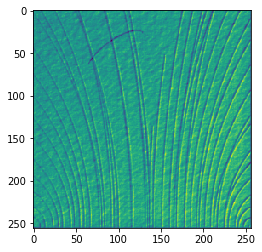

In [32]:
img = defect_imgs[38]
plt.imshow(img.reshape((256, 256)))

In [33]:
predicted = autoencoder.predict(defect_imgs)

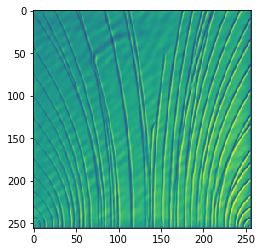

In [34]:
plt.imshow(predicted[38].reshape((256,256)))

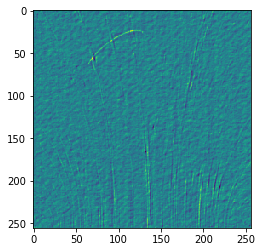

In [35]:
plt.imshow(predicted[38].reshape((256,256)) - img.reshape((256, 256)))